# Imports

In [1]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer

import warnings
warnings.simplefilter('ignore')

# Data

We will use the Wisconsin breast cancer dataset for illustration:

In [2]:
data = load_breast_cancer()
print('Target Labels\n-------------')
for label, name in enumerate(data.target_names):
    print(label, ':', name)
print('\nFeatures\n-------------')
for index, feature in enumerate(data.feature_names):
    print(index, ':', feature)

Target Labels
-------------
0 : malignant
1 : benign

Features
-------------
0 : mean radius
1 : mean texture
2 : mean perimeter
3 : mean area
4 : mean smoothness
5 : mean compactness
6 : mean concavity
7 : mean concave points
8 : mean symmetry
9 : mean fractal dimension
10 : radius error
11 : texture error
12 : perimeter error
13 : area error
14 : smoothness error
15 : compactness error
16 : concavity error
17 : concave points error
18 : symmetry error
19 : fractal dimension error
20 : worst radius
21 : worst texture
22 : worst perimeter
23 : worst area
24 : worst smoothness
25 : worst compactness
26 : worst concavity
27 : worst concave points
28 : worst symmetry
29 : worst fractal dimension


# Nested CV (5x2-fold)

In [3]:
# Splitting data into train and test set (to assess generalization error)
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initializing Classifiers
clf_lr  = LogisticRegression(solver='lbfgs', random_state=0, max_iter=1000)
clf_rf  = RandomForestClassifier(random_state=0)
clf_svc = SVC(random_state=0)
clf_knn = KNeighborsClassifier()

# Building the model pipelines incl. preprocessing where needed 
# Note that the random forest does not need feature scaling
pipe_lr  = Pipeline([('std', StandardScaler()),
                     ('clf_lr', clf_lr)])

pipe_svc = Pipeline([('std', StandardScaler()),
                     ('clf_svc', clf_svc)])

pipe_knn = Pipeline([('std', StandardScaler()),
                     ('clf_knn', clf_knn)])

# Setting up the parameter grids
param_grid_lr  = [{'clf_lr__penalty': ['l2'],
                   'clf_lr__C': np.logspace(-4, 4, 9)}]

param_grid_knn = [{'clf_knn__n_neighbors': list(range(1, 10)),
                   'clf_knn__p': [1, 2],
                   'clf_knn__leaf_size': np.arange(10,51,10)}]

param_grid_rf  = [{'n_estimators': [10, 50, 100, 250, 500, 1000],
                   'min_samples_leaf': [1, 3, 5],
                   'max_features': ['sqrt', 'log2']}]

param_grid_svc = [{'clf_svc__kernel': ['rbf'],
                   'clf_svc__C': np.logspace(-4, 4, 9),
                    'clf_svc__gamma': np.logspace(-4, 0, 4)},
                  {'clf_svc__kernel': ['linear'],
                   'clf_svc__C': np.logspace(-4, 4, 9)}]

# Setting up multiple GridSearchCV objects, one for each algorithm
gridcvs = {}
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=4)

for pgrid, est, name in zip((param_grid_lr, param_grid_knn,
                             param_grid_rf, param_grid_svc),
                            (pipe_lr, pipe_knn, clf_rf, pipe_svc),
                            ('LogisticRegression', 'KNN', 'RF', 'SVM')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring='accuracy',
                       n_jobs=1,
                       cv=inner_cv,
                       verbose=0,
                       refit=True)
    gridcvs[name] = gcv

What are hyperparameters? Hyperparameters are the parameters of the learning algorithm itself, which we have to specify a priori, i.e., before model fitting. In contrast, model parameters are parameters which arise as a result of the fit [1]. For instance, in a `sklearn` Logistic Regression model, the regularization parameter `C` is a hyperparameter (to be specified before calling the `.fit()` method) while the fitted feature coefficients are model parameters.

In [4]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
outer_scores = {}

for name, gs_est in sorted(gridcvs.items()):
    nested_score = cross_val_score(gs_est, 
                                   X=X_train, 
                                   y=y_train, 
                                   cv=outer_cv,
                                   n_jobs=1)
    outer_scores[name] = nested_score
    print(f'{name}: outer accuracy {100*nested_score.mean():.2f} +/- {100*nested_score.std():.2f}')

KNN: outer accuracy 96.70 +/- 1.39
LogisticRegression: outer accuracy 98.46 +/- 1.32
RF: outer accuracy 94.51 +/- 2.60
SVM: outer accuracy 97.58 +/- 1.46


Note that we do not care about hyperparameter values, but about which learning algorithm (Random Forest, Logistic Regression etc.) yields stable results irrespective of their particular choice of hyperparameters. The outer-fold cross-validation is not concerned with hyperparameter selection (this is what is done inside the inner fold), but with estimating the generalization error of the learning algorithms. (In this sense, hyperparameter tuning can be thought of as part of the model fitting process [2], which is being done within the inner fold.)

The goal at this stage is to find a learning algorithm which performs well irrespective of the particular subset of the training set chosen for the model training (and hence specific hyperparameter values). This assumes that the 5 (number of outer fold splits) potentially different models are comparable to the final model trained on the full training data, or at least comparable to each other. Since the number of training samples in the cross-validation procedure is smaller than in the full training set, we might get a pessimistically biased estimate of the model performance, depending on how the performance of the learning algorithm varies with the size of the training set [3].

If the hyperparameter optimization process is unstable, i.e., if the models determined in the inner cross-validation fold are not comparable to each other (e.g. since they are overfitting the data or since the data is noisy), we expect the learning algorithm to exhibit high variance in the outer cross-validation loop. Hence, in order to be confident that our selected learning algorithm will have a similar performance on yet unseen data when fitted on the full training data, we select the learning algorithm with high mean accuracy and low variance on the outer cross-validation loop.

In [5]:
# fit "best" algorithm on the full training set
algo_best = 'LogisticRegression'
algo = gridcvs[algo_best]
algo.fit(X_train, y_train)
train_acc = accuracy_score(y_true=y_train, y_pred=algo.predict(X_train))
test_acc = accuracy_score(y_true=y_test, y_pred=algo.predict(X_test))

# evaluate performance and compare to cross-validation results
print(f'Accuracy (mean cross-vaidated score of the best_estimator): {100*algo.best_score_:.2f}')
print(f'Best Parameters: {gridcvs[algo_best].best_params_}')

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Accuracy (mean cross-vaidated score of the best_estimator): 97.14
Best Parameters: {'clf_lr__C': 1.0, 'clf_lr__penalty': 'l2'}
Training Accuracy: 98.90
Test Accuracy: 98.25


Note that the mean cross-validated accuracy on the training set is lower than the test accuracy, indicating that the cross-validation score is a pessimistic estimate (i.e., more training data makes the model better).

The final step (which we omit here) is to train the final algorithm with the final set of hyperparameters on the full available data before deploying it in the real world. After fitting with the full available data we do no longer have an estimate of the generalization error of the resulting model. However, since we have thoroughly estimated the generalization error beforehand, we have reason to believe that the model will not perform worse on unseen data (sampled from the same distribution as training and test data) than the model whose generalization error we estimated above with the help of the test set. 

### Learning curves for estimating the variation of the learning algorithm performance with training set size

Lastly, to estimate how the model performance varies with training set size, we plot learning curves for our classifiers (standard parameters). This also illustrates why we might get a pessimistic estimate when doing cross-validation: the training data might just be too small for our learning algorithm to get to its best possible performance.

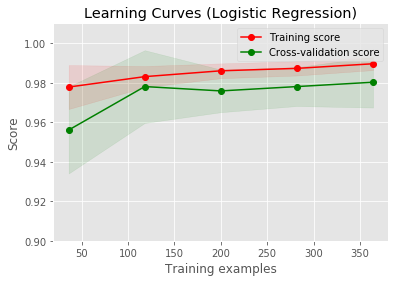

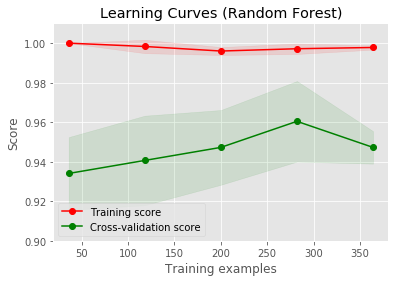

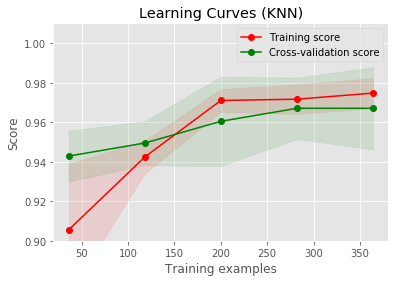

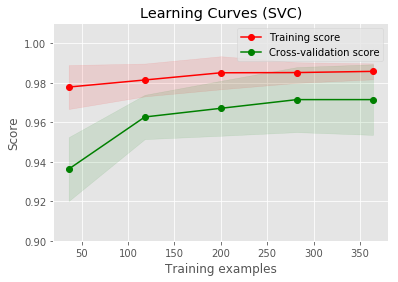

In [6]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

def plot_learning_curve(estimator, clf, X, y, ylim=None, cv=None, train_sizes=None):
    plt.figure()
    plt.title(f'Learning Curves ({clf})')
    plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.grid(True)
    return

train_sizes = np.linspace(.1, 1.0, 5)
ylim = (0.9, 1.01)
cv = 5
plot_learning_curve(pipe_lr, "Logistic Regression", X_train, y_train, 
                    ylim=ylim, cv=cv, train_sizes=train_sizes)
plot_learning_curve(clf_rf, "Random Forest", X_train, y_train, 
                    ylim=ylim, cv=cv, train_sizes=train_sizes)
plot_learning_curve(pipe_knn, "KNN", X_train, y_train, 
                    ylim=ylim, cv=cv, train_sizes=train_sizes)
plot_learning_curve(pipe_svc, "SVC", X_train, y_train, 
                    ylim=ylim, cv=cv, train_sizes=train_sizes)

plt.show()

Note that the training score in the learning curve for Logistic Regression (KNN, SVC) increases with larger sample size rather than decreasing with increasing training size. This indicates that the size of the training set is not sufficient to fit the model parameters well (not surprisingly, given that we have 30 features - from the "one in ten" rule of thumb we would expect to need > 300 data points to fit our Logistic Regression model well).

Besides, the standard deviation of the cross-validation score ($\approx 1$) for Logistic Regression is comparable with the standard deviation obtained in the outer fold of the nested cross-validation routine above, indicating that the hyperparameter optimization in the inner loop is stable, i.e., the resulting scores vary not more than is expected. In contast, the Random Forest is severely overfitting.

# Appendix

## References

[1] *Model evaluation, model selection, and algorithm selection in machine learning* by Sebastian Raschka, [PDF](https://sebastianraschka.com/pdf/manuscripts/model-eval.pdf).

[2] Stackexchange discussions [here](https://stats.stackexchange.com/questions/65128/nested-cross-validation-for-model-selection), [here](https://stats.stackexchange.com/questions/251752/model-selection-problem-using-nested-cross-validation-in-presence-of-several-alt), and [here](https://stats.stackexchange.com/questions/232897/how-to-build-the-final-model-and-tune-probability-threshold-after-nested-cross-v)

[3] Hastie T., Tibshirani R., and Friedman J., *The Elements of Statistical Learning*, New York, NY, USA: Springer New York Inc. (2008). 

## Version information

In [7]:
import IPython

# print system information (but not packages)
print(IPython.sys_info())

# print information on installed modules
!pip freeze 

{'commit_hash': '59a7834d2',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/Users/dslr/miniconda3/envs/modelselection_blog/lib/python3.7/site-packages/IPython',
 'ipython_version': '7.1.1',
 'os_name': 'posix',
 'platform': 'Darwin-18.2.0-x86_64-i386-64bit',
 'sys_executable': '/Users/dslr/miniconda3/envs/modelselection_blog/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.7.1 (default, Oct 23 2018, 14:07:42) \n'
                '[Clang 4.0.1 (tags/RELEASE_401/final)]'}
appnope==0.1.0
backcall==0.1.0
bleach==3.0.2
certifi==2018.10.15
cycler==0.10.0
decorator==4.3.0
entrypoints==0.2.3
ipykernel==5.1.0
ipython==7.1.1
ipython-genutils==0.2.0
ipywidgets==7.4.2
jedi==0.13.1
Jinja2==2.10
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==6.0.0
jupyter-core==4.4.0
kiwisolver==1.0.1
MarkupSafe==1.1.0
matplotlib==3.0.1
mistune==0.8.4
mkl-fft==1.0.6
mkl-random==1.0.1
nbconvert==5.3.1
nbformat==4.4.0
notebook==5.7.2
numpy==1.15.4
